In [1]:
import pandas as pd
import numpy as np


# 1. LOAD RAW DATA (skip corrupted lines)

df = pd.read_csv(
    "/Users/architap/Downloads/redditSubmissions.csv",
    on_bad_lines='skip',
    engine='python'
)

print("Loaded dataset shape:", df.shape)

ModuleNotFoundError: No module named 'pandas'

In [4]:
# 2. DROP COLUMNS WE DO NOT WANT
#    - They are redundant OR they leak post-outcome information

cols_to_drop = [
    '#image_id', 'rawtime', 'localtime',
    'reddit_id', 'username',
    'total_votes', 'number_of_upvotes', 'number_of_downvotes'
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

print("After dropping columns:", df.shape)

After dropping columns: (132303, 5)


In [5]:
# 3. DROP ROWS WITH MISSING TITLES

df = df[df['title'].notnull()].copy()
df['title'] = df['title'].astype(str)

print("After dropping missing titles:", df.shape)


After dropping missing titles: (132302, 5)


In [6]:
# 4. PROCESS TIMESTAMP → extract hour + day-of-week

df['created'] = pd.to_datetime(df['unixtime'], unit='s', errors='coerce')

df['hour'] = df['created'].dt.hour
df['dayofweek'] = df['created'].dt.dayofweek

print("Extracted time features.")



Extracted time features.


In [7]:
# 5. FEATURE ENGINEERING ON TITLES

df['title_len'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().str.len()
df['has_question'] = df['title'].str.contains(r'\?', regex=True).astype(int)
df['has_exclamation'] = df['title'].str.contains('!').astype(int)

print("Created text-based features.")



Created text-based features.


In [8]:
# 6. DEFINE POPULARITY: TOP 10% SCORE PER SUBREDDIT

df['pop_threshold'] = df.groupby('subreddit')['score'].transform(
    lambda x: x.quantile(0.90)
)

df['popular'] = (df['score'] >= df['pop_threshold']).astype(int)

print("Defined popularity labels.")

Defined popularity labels.


In [9]:
# 7. FINAL MODELING DATAFRAME

df_model = df[[
    'title',
    'subreddit',
    'hour',
    'dayofweek',
    'title_len',
    'word_count',
    'has_question',
    'has_exclamation',
    'popular'
]]

print("Final cleaned dataset shape:", df_model.shape)

# 8. SAVE CLEANED CSV

output_path = "/Users/architap/Downloads/redditSubmissions_cleaned.csv"
df_model.to_csv(output_path, index=False)

print("Saved cleaned dataset to:", output_path)

Final cleaned dataset shape: (132302, 9)
Saved cleaned dataset to: /Users/architap/Downloads/redditSubmissions_cleaned.csv


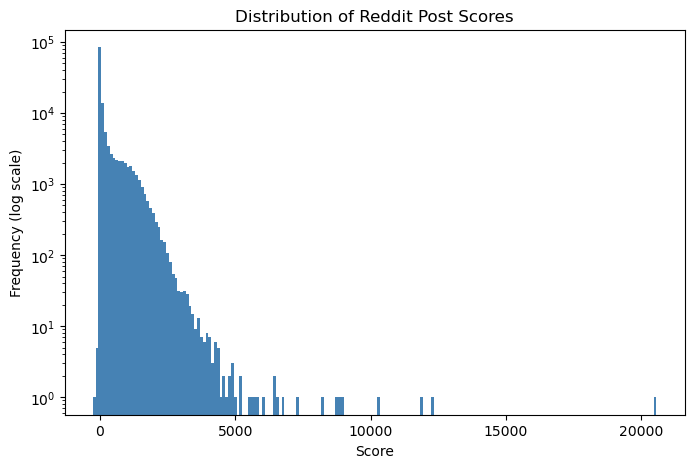

In [10]:
# Relevant plots

import matplotlib.pyplot as plt

# Score distribution
plt.figure(figsize=(8,5))
plt.hist(df['score'], bins=200, color='steelblue')
plt.yscale('log')
plt.xlabel("Score")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Reddit Post Scores")
plt.show()

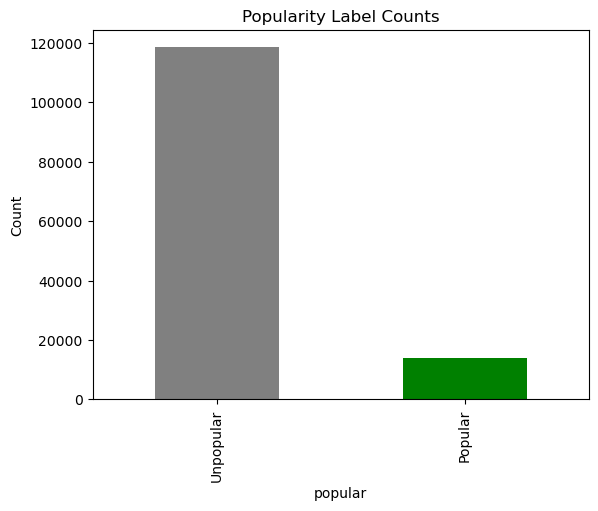

In [11]:
df['popular'].value_counts().plot(kind='bar', color=['gray','green'])
plt.xticks([0,1], ['Unpopular','Popular'])
plt.title("Popularity Label Counts")
plt.ylabel("Count")
plt.show()

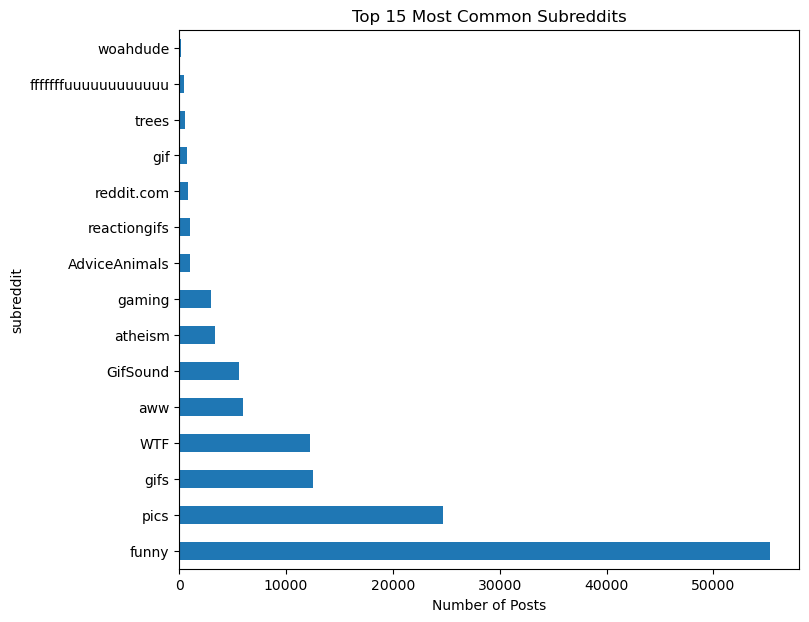

In [12]:
df['subreddit'].value_counts().head(15).plot(kind='barh', figsize=(8,7))
plt.title("Top 15 Most Common Subreddits")
plt.xlabel("Number of Posts")
plt.show()

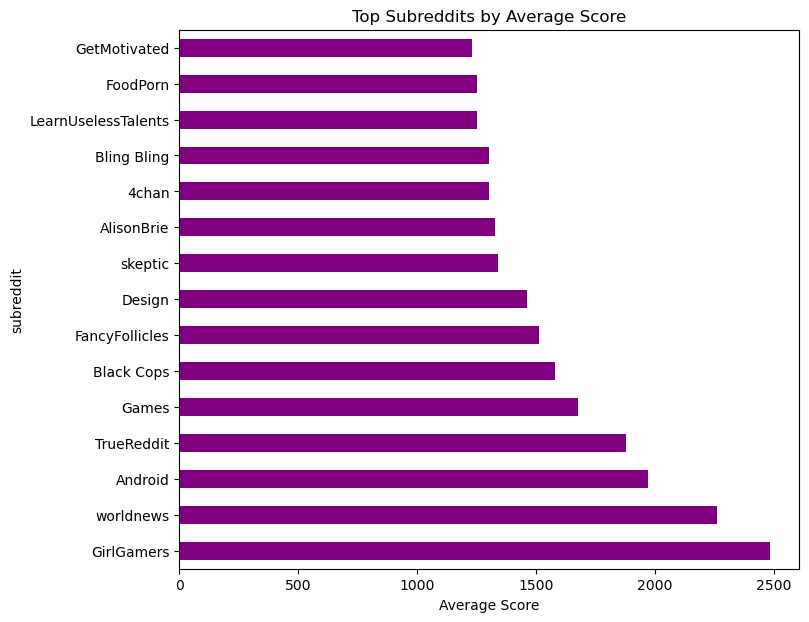

In [13]:
df.groupby('subreddit')['score'].mean().sort_values(ascending=False).head(15).plot(
    kind='barh', figsize=(8,7), color='purple'
)
plt.title("Top Subreddits by Average Score")
plt.xlabel("Average Score")
plt.show()

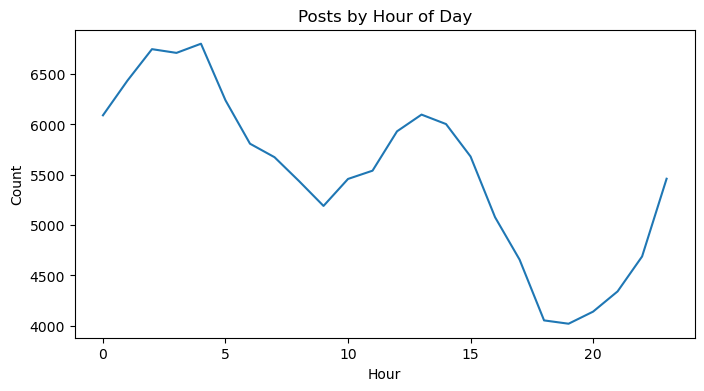

In [14]:
df['hour'].value_counts().sort_index().plot(kind='line', figsize=(8,4))
plt.title("Posts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

In [15]:
from collections import Counter
import re

def tokenize(text):
    return re.sub(r'[^A-Za-z\s]', '', text.lower()).split()

word_counts = Counter()
df['title'].apply(lambda x: word_counts.update(tokenize(x)))

pd.DataFrame(word_counts.most_common(20), columns=['word','count'])

,word,count
0,i,30036
1,the,28098
2,a,23909
3,this,17277
4,to,16311
5,my,16057
6,of,12665
7,in,10462
8,is,10095
9,when,9256
